In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split

In [ ]:
dic = pickle.load(open('/global/cfs/cdirs/desc-wl/users/aplazas/trainingDataSet200kHSC_RC2.pkl', 'rb'))
#dic = pickle.load(open('trainingDataSetSmallHSC_RC2.pkl', 'rb'))
data=pd.DataFrame(dic)

StarID=np.array(data.columns)
star= np.array(data.iloc[0])

dicc= dict(zip(StarID, star))

In [3]:
#Tener en cuenta que las imagenes ya están normalizadas 
all_images= np.array(data.iloc[0])
# Convierte a un array NumPy 3D: (N, 25, 25)
all_images = np.stack(all_images)  
# Agrega un canal para PyTorch: (N, 1, 25, 25)
all_images = np.expand_dims(all_images, axis=1)

In [4]:
piff = np.array(data.iloc[2])
piff=np.stack(piff)
piff=np.expand_dims(piff,axis=1)

In [5]:
# Convierte los arreglos a tensores con tipo float32 para compatibilidad con PyTorch
tensor_images = torch.tensor(all_images, dtype=torch.float32)

# Dataset completo (usamos las imágenes como entrada y como objetivo)
dataset = TensorDataset(tensor_images, tensor_images)

# Define proporciones para entrenamiento y validación
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
val_size = len(dataset) - train_size  # 20% para validación

# Fijar la semilla
generator = torch.Generator().manual_seed(1)

# Divide el dataset aleatoriamente
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Crea DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #shuffle=True mezcla aleatoriamente los datos 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print(all_images.min(), all_images.max())

-2.529014 4.7837954


In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super(Autoencoder, self).__init__()
         
        
        # Encoder (capas progresivamente más pequeñas)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(625,312),
            nn.ReLU(),
            nn.Linear(312, 156), 
            nn.ReLU(),
            nn.Linear(156, 78),
            nn.ReLU(),
            nn.Linear(78, latent_dim)

            
        )
        
        # Decoder (capas simétricas al encoder)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 78),
            nn.ReLU(),
            nn.Linear(78, 156),
            nn.ReLU(),
            nn.Linear(156, 312),
            nn.ReLU(),
            nn.Linear(312, 625),
            nn.Softmax(dim=1),
            nn.Unflatten(1, (1, 25, 25)),  # Volver a la forma original
            

        )

    def forward(self, x: torch.Tensor): # x es el tensor de entrada  
        z = self.encoder(x) # El resultado de z es el espacio latente (lo que aprendió la red)
        out = self.decoder(z) #out es la versión reconstruida de la imagen 
        return out

In [7]:
# Dimensión del espacio latente
latent_dim = 32

# Dispositivo
device = torch.device("cuda")

# Modelo
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

# Optimizador
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

# Pérdida
loss_fn = nn.MSELoss()

# Número de épocas
num_epochs = 500

loss_per_epoch = []
val_loss_per_epoch = []

autoencoder.train()  # Pone el modelo en modo entrenamiento

for epoch in range(num_epochs):  # Se repite el entrenamiento por cada época
    total_loss = 0  # Inicializa la pérdida acumulada de la época

    for x_batch, _ in train_loader:  # Itera sobre los minibatches del conjunto de entrenamiento
        #  El guion bajo _ ignora los targets, ya que en un autoencoder el input es el target.
        x_batch = x_batch.to(device)  # Envia el lote al dispositivo (En este caso CPU)
        optimizer.zero_grad()  # Reinicia los gradientes acumulados, Esto es importante porque PyTorch acumula los gradientes por defecto.
        x_hat = autoencoder(x_batch)  # Se pasan los datos por el autoencoder (reconstrucción)
        loss = loss_fn(x_hat, x_batch)  # Se calcula la pérdida entre entrada y reconstrucción. Toma x_batch como entrada y produce x_hat, la imagen reconstruida.
        loss.backward()  # Calcula los gradientes de la pérdida con respecto a los parámetros del modelo 
        optimizer.step()  # Actualiza los pesos del modelo según los gradientes y la tasa de aprendizaje.
        total_loss += loss.item()  #  Acumula la pérdida de este minibatch para luego calcular el promedio.

    avg_loss = total_loss / len(train_loader.dataset)  # Calcula la pérdida promedio por muestra en toda la época 
    loss_per_epoch.append(avg_loss)  #  Guarda la pérdida promedio de la época para monitorear el entrenamiento

    # En promedio, el modelo cometió un error de avg_loss por imagen en esa época.

    # Validación
    autoencoder.eval()  # Cambia a modo evaluación
    val_loss = 0
    with torch.no_grad():
        for x_val, _ in val_loader:
            x_val = x_val.to(device)
            x_hat_val = autoencoder(x_val)
            val_loss += loss_fn(x_hat_val, x_val).item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_loss_per_epoch.append(avg_val_loss)

    if (epoch+1)%50==0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.20f}, Val Loss: {avg_val_loss:.20f}")

    autoencoder.train()  # Regresa a modo entrenamiento. Tras validar es necesario seguir entrenando

Epoch 50, Train Loss: 0.00000011882337734370, Val Loss: 0.00000007680693170211
Epoch 100, Train Loss: 0.00000011508148960786, Val Loss: 0.00000007297423303458
Epoch 150, Train Loss: 0.00000011253107018110, Val Loss: 0.00000007040714063107
Epoch 200, Train Loss: 0.00000011280934467166, Val Loss: 0.00000007037708926866
Epoch 250, Train Loss: 0.00000011226527499524, Val Loss: 0.00000007027428543395
Epoch 300, Train Loss: 0.00000011213573590716, Val Loss: 0.00000007013777038664
Epoch 350, Train Loss: 0.00000011138252552279, Val Loss: 0.00000006935843576982
Epoch 400, Train Loss: 0.00000011123560803235, Val Loss: 0.00000006928015684990
Epoch 450, Train Loss: 0.00000011109249153485, Val Loss: 0.00000006906943457588
Epoch 500, Train Loss: 0.00000011064654024207, Val Loss: 0.00000006868897745666


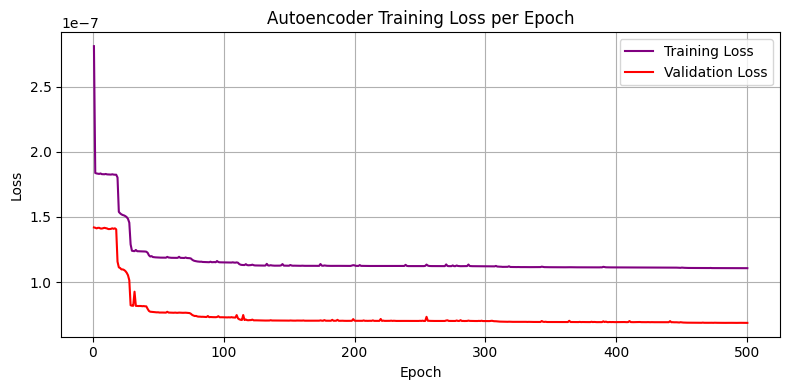

In [8]:
# Graficar pérdida por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), loss_per_epoch, label="Training Loss", color='purple')
plt.plot(range(1, num_epochs + 1), val_loss_per_epoch, label="Validation Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

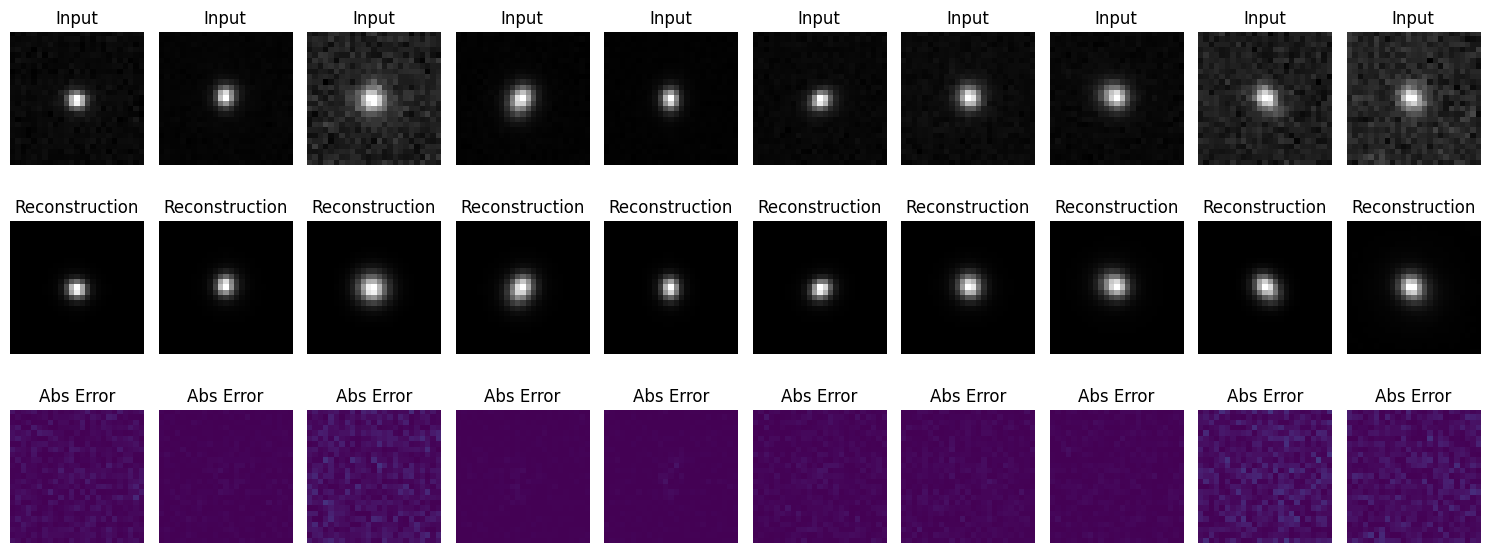

MSE between inputs and reconstructions: 0.00001115980194299482


In [9]:
# Poner el modelo en modo evaluación
autoencoder.eval()

# Tomar un batch de datos (por ejemplo, del conjunto de validación)
x_val_batch, _ = next(iter(val_loader))
x_val_batch = x_val_batch.to(device)

with torch.no_grad():
    x_hat = autoencoder(x_val_batch)

# Calcular el error absoluto entre imagen original y reconstruida
errors = torch.abs(x_val_batch - x_hat)

# Visualizar las primeras N imágenes, sus reconstrucciones y el error
n = 10
plt.figure(figsize=(15, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_batch[i, 0].cpu(), cmap="gray")
    ax.set_title("Input")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_hat[i, 0].cpu(), cmap="gray")
    ax.set_title("Reconstruction")
    plt.axis("off")

    # Error absoluto
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(errors[i, 0].cpu(), cmap="viridis", vmax=0.05)
    ax.set_title("Abs Error")
    plt.axis("off")

plt.tight_layout()
plt.show()

MSE=nn.MSELoss()(x_hat, x_batch).item()

print(f"MSE between inputs and reconstructions: {MSE:.20f}")


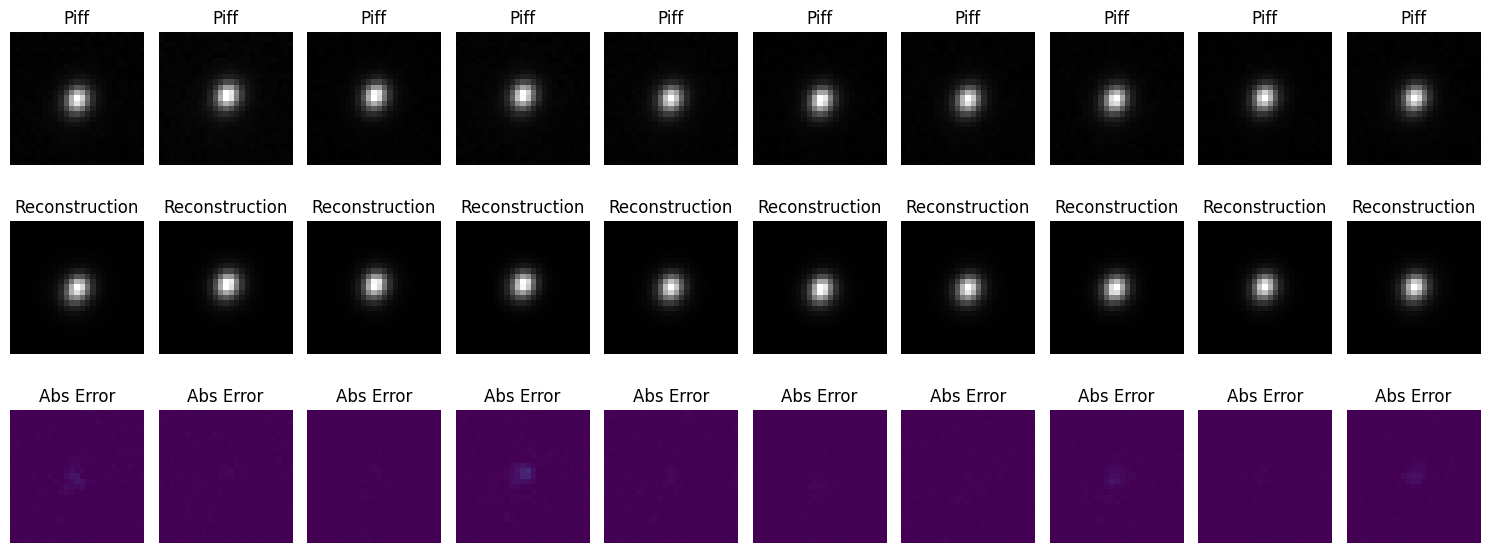

MSE between reconstructions and piff: 0.00000038618617281827


In [10]:
# Para comparar con piff 

# Poner el modelo en modo evaluación
autoencoder.eval()

# Loaders sin shuffle para mantener el orden
train_loader = DataLoader(all_images, batch_size=32, shuffle=False) 
piff_loader  = DataLoader(piff, batch_size=32, shuffle=False)

all_errors = []
all_inputs = []
all_reconstructions = []
all_piffs = []

with torch.no_grad():
    for x_val_batch, x_piff_batch in zip(train_loader, piff_loader):
        x_val_batch = x_val_batch.to(device)
        x_piff_batch = x_piff_batch.to(device)

        # Reconstrucción
        x_hat = autoencoder(x_val_batch)

        # Guardar errores y datos para visualización
        errors = torch.abs(x_piff_batch - x_hat)
        all_errors.append(errors.cpu())
        all_inputs.append(x_val_batch.cpu())
        all_reconstructions.append(x_hat.cpu())
        all_piffs.append(x_piff_batch.cpu())


# Concatenar todo
all_errors = torch.cat(all_errors)
all_inputs = torch.cat(all_inputs)
all_reconstructions = torch.cat(all_reconstructions)
all_piffs = torch.cat(all_piffs)

# Mostrar las primeras N imágenes
n = 10
plt.figure(figsize=(15, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(all_piffs[i, 0], cmap="gray")
    ax.set_title("Piff")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(all_reconstructions[i, 0], cmap="gray")
    ax.set_title("Reconstruction")
    plt.axis("off")

    # Error absoluto
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(all_errors[i, 0], cmap="viridis", vmax=0.05)
    ax.set_title("Abs Error")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Calcular MSE total entre todo x_hat y piff
MSE = nn.MSELoss()(all_reconstructions, all_piffs).item()
print(f"MSE between reconstructions and piff: {MSE:.20f}")